# Config

In [ ]:
import json
import torch
import numpy as np
import mdtraj as md
import nglview as nv

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

PHI_ANGLE = [4, 6, 8, 14]
PSI_ANGLE = [6, 8, 14, 16]
ALANINE_HEAVY_ATOM_IDX = [1, 4, 5, 6, 8, 10, 14, 15, 16, 18]
ALANINE_HEAVY_ATOM_IDX_TBG = [0, 4, 5, 6, 8, 10, 14, 15, 16, 18]

n_particles = 22
n_dimensions = 3
scaling = 10
dim = n_particles * n_dimensions

def compute_dihedral(positions):
    """http://stackoverflow.com/q/20305272/1128289"""
    def dihedral(p):
        if not isinstance(p, np.ndarray):
            p = p.numpy()
        b = p[:-1] - p[1:]
        b[0] *= -1
        v = np.array([v - (v.dot(b[1]) / b[1].dot(b[1])) * b[1] for v in [b[0], b[2]]])
        
        # Normalize vectors
        v /= np.sqrt(np.einsum('...i,...i', v, v)).reshape(-1, 1)
        b1 = b[1] / np.linalg.norm(b[1])
        x = np.dot(v[0], v[1])
        m = np.cross(v[0], b1)
        y = np.dot(m, v[1])
        
        return np.arctan2(y, x)
    
    return np.array(list(map(dihedral, positions)))

# Timelag dataset

## Original dataset

In [33]:
current_xyz = torch.load("../dataset/alanine/300.0/timelag-10n-v1/xyz-aligned.pt")
print(current_xyz.shape)
phi = compute_dihedral(current_xyz[:, PHI_ANGLE])
psi = compute_dihedral(current_xyz[:, PSI_ANGLE])

torch.Size([10000, 22, 3])


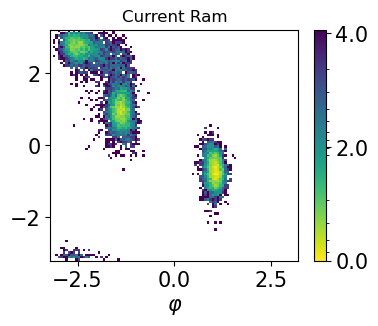

In [34]:
fig, ax = plt.subplots(figsize=(4, 3))
plot_range = [-3.2, 3.2]
h, x_bins, y_bins, im = ax.hist2d(phi, psi, 100, norm=LogNorm(), range=[plot_range,plot_range],rasterized=True)
ticks = np.array([np.exp(-6)*h.max(), np.exp(-4.0)*h.max(),np.exp(-2)*h.max(), h.max()])
ax.set_title("Current Ram")
ax.set_xlabel(r"$\varphi$", fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
cbar = fig.colorbar(im, ticks=ticks)
cbar.ax.set_yticklabels([6.0,4.0,2.0,0.0], fontsize=15)
cbar.ax.invert_yaxis()

In [35]:
timelag_xyz = torch.load("../dataset/alanine/300.0/timelag-10n-v1/xyz-aligned.pt")
print(timelag_xyz.shape)
phi = compute_dihedral(timelag_xyz[:, PHI_ANGLE])
psi = compute_dihedral(timelag_xyz[:, PSI_ANGLE])

torch.Size([10000, 22, 3])


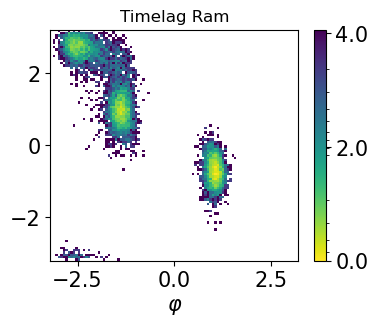

In [36]:
fig, ax = plt.subplots(figsize=(4, 3))
plot_range = [-3.2, 3.2]
h, x_bins, y_bins, im = ax.hist2d(phi, psi, 100, norm=LogNorm(), range=[plot_range,plot_range],rasterized=True)
ticks = np.array([np.exp(-6)*h.max(), np.exp(-4.0)*h.max(),np.exp(-2)*h.max(), h.max()])
ax.set_title("Timelag Ram")
ax.set_xlabel(r"$\varphi$", fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
cbar = fig.colorbar(im, ticks=ticks)
cbar.ax.set_yticklabels([6.0,4.0,2.0,0.0], fontsize=15)
cbar.ax.invert_yaxis()

## Kabsch test

In [6]:
current_xyz = torch.load("../dataset/alanine/300.0/10nano-v2/current-xyz.pt")
timelag_xyz = torch.load("../dataset/alanine/300.0/10nano-v2/timelag-xyz.pt")
current_xyz_aligned = torch.load("../dataset/alanine/300.0/10nano-v2/current-xyz-aligned.pt")
timelag_xyz_aligned = torch.load("../dataset/alanine/300.0/10nano-v2/timelag-xyz-aligned.pt")
reference_frame = torch.load("../data/alanine/c5.pt")['xyz'][0]
print(current_xyz.shape, timelag_xyz.shape, current_xyz_aligned.shape, timelag_xyz_aligned.shape, reference_frame.shape)

torch.Size([10000, 22, 3]) torch.Size([10000, 22, 3]) torch.Size([10000, 22, 3]) torch.Size([10000, 22, 3]) torch.Size([22, 3])


In [ ]:
def kabsch(
    P: torch.Tensor,
    Q: torch.Tensor,
) -> torch.Tensor:
    '''
        Kabsch algorithm for aligning two sets of points
        Args:
            P (torch.Tensor): Current positions (N, 3)
            Q (torch.Tensor): Reference positions (N, 3)
        Returns:
            torch.Tensor: Aligned positions (N, 3)
    '''
    centroid_P = torch.mean(P, dim=-2, keepdims=True)
    centroid_Q = torch.mean(Q, dim=-2, keepdims=True)
    P_centered = P - centroid_P
    Q_centered = Q - centroid_Q

    # Compute the covariance matrix
    H = torch.matmul(P_centered.transpose(-2, -1), Q_centered)
    U, S, Vt = torch.linalg.svd(H)
    d = torch.det(torch.matmul(Vt.transpose(-2, -1), U.transpose(-2, -1))) 
    Vt[d < 0.0, -1] *= -1.0

    # Optimal rotation and translation
    R = torch.matmul(Vt.transpose(-2, -1), U.transpose(-2, -1))
    t = centroid_Q - torch.matmul(centroid_P, R.transpose(-2, -1))
    P_aligned = torch.matmul(P, R.transpose(-2, -1)) + t
    
    return P_aligned

In [7]:
computed_current_xyz_aligned = torch.empty(size=(current_xyz.shape))

for idx, frame in enumerate(tqdm(current_xyz)):
    computed_current_xyz_aligned[idx] = kabsch(frame, reference_frame)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [17]:
err = (computed_current_xyz_aligned - current_xyz_aligned)
err2 = (computed_current_xyz_aligned - current_xyz)
print(err.sum())
print(err2.sum())

tensor(0.)
tensor(226544.0312)


# Projection dataset

In [18]:
def kabsch(
    P: torch.Tensor,
    Q: torch.Tensor,
) -> torch.Tensor:
    '''
        Kabsch algorithm for aligning two sets of points
        Args:
            P (torch.Tensor): Current positions (N, 3)
            Q (torch.Tensor): Reference positions (N, 3)
        Returns:
            torch.Tensor: Aligned positions (N, 3)
    '''
    centroid_P = torch.mean(P, dim=-2, keepdims=True)
    centroid_Q = torch.mean(Q, dim=-2, keepdims=True)
    P_centered = P - centroid_P
    Q_centered = Q - centroid_Q

    # Compute the covariance matrix
    H = torch.matmul(P_centered.transpose(-2, -1), Q_centered)
    U, S, Vt = torch.linalg.svd(H)
    d = torch.det(torch.matmul(Vt.transpose(-2, -1), U.transpose(-2, -1))) 
    Vt[d < 0.0, -1] *= -1.0

    # Optimal rotation and translation
    R = torch.matmul(Vt.transpose(-2, -1), U.transpose(-2, -1))
    t = centroid_Q - torch.matmul(centroid_P, R.transpose(-2, -1))
    P_aligned = torch.matmul(P, R.transpose(-2, -1)) + t
    
    return P_aligned

projection_data = torch.load("../data/alanine/uniform.pt")
reference_frame = torch.load("../data/alanine/c5.pt")['xyz'][0]
print(projection_data.shape)

torch.Size([10000, 22, 3])


In [19]:
aligned_data_list = torch.empty(size=(projection_data.shape))

for idx, data in enumerate(tqdm(projection_data)):
	aligned_data_list[idx] = kabsch(data, reference_frame)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [20]:
unifom_xyz_aligned = torch.load("../data/alanine/uniform-xyz-aligned.pt")
err = (aligned_data_list - unifom_xyz_aligned)
print(err.sum())
# print(aligned_data_list.shape)

tensor(-281.4617)


In [21]:
print(aligned_data_list.shape)
torch.save(aligned_data_list, "../data/alanine/uniform-xyz-aligned.pt")

torch.Size([10000, 22, 3])
